<a href="https://colab.research.google.com/github/beifa/Bengali.AI/blob/master/resnext50_32x4d%26B3model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from PIL import Image


import albumentations
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as FF
from albumentations import (
    PadIfNeeded,
    Crop,
    OneOf,
    Rotate  
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#kaggle
# sample_submission = pd.read_csv("../input/bengaliai-cv19/sample_submission.csv")
# test = pd.read_csv("../input/bengaliai-cv19/test.csv")
# train = pd.read_csv("../input/bengaliai-cv19/train.csv")
# f0 = pd.read_feather('/kaggle/input/bengali-resize/train_data_0_128.feather')
# f1 = pd.read_feather('/kaggle/input/bengali-resize/train_data_1_128.feather')
# f2 = pd.read_feather('/kaggle/input/bengali-resize/train_data_2_128.feather')
# f3 = pd.read_feather('/kaggle/input/bengali-resize/train_data_3_128.feather')
#colab
# PATH_RESIZE = '/content/drive/My Drive/Bengali/data/resize/'
PATH = '/content/drive/My Drive/Bengali/data/'

train = pd.read_csv(PATH + 'train.csv')
#test = pd.read_csv(PATH + 'test.csv')
train_fold = pd.read_csv(PATH + 'train_folds.csv')
f0 = pd.read_feather(PATH + 'train_data_0_128.feather')
f1 = pd.read_feather(PATH + 'train_data_1_128.feather')
f2 = pd.read_feather(PATH + 'train_data_2_128.feather')
f3 = pd.read_feather(PATH + 'train_data_3_128.feather')
#home
# path = os.path.join('C:/Users/pka/kaggle/bengali/data', 'train_data_0_64.feather')
# path1 = os.path.join('C:/Users/pka/kaggle/bengali/data', 'train_data_1_64.feather')
# path2 = os.path.join('C:/Users/pka/kaggle/bengali/data', 'train_data_2_64.feather')
# path3 = os.path.join('C:/Users/pka/kaggle/bengali/data', 'train_data_3_64.feather')
# f0 = pd.read_feather(path)
# f1 = pd.read_feather(path1)
# f2 = pd.read_feather(path2)
# f3 = pd.read_feather(path3)

# path_train = os.path.join('C:/Users/pka/kaggle/bengali/data', 'train.csv')
# train= pd.read_csv(path_train)

images = pd.concat([f0, f1, f2, f3], ignore_index = True)
del f0
del f1
del f2
del f3
gc.collect()

0

In [0]:
# !pip install efficientnet_pytorch
# from efficientnet_pytorch import EfficientNet

# !pip install '/kaggle/input/model-eff/efficientnet_pytorch-0.6.1/'
# from efficientnet_pytorch import EfficientNet

'densenet121',
'densenet161',
'densenet169',
'densenet201', 
'resnet101',
'resnet152',
'resnet18',
'resnet34',
'resnet50',
'resnext101_32x8d',
'resnext50_32x4d'

## Test corp

In [0]:
from albumentations import (
    PadIfNeeded,
    Crop)

In [0]:
def rand_num():
  p = np.random.randn()
  val = np.arange(1,10)
  if p > 0:
    num  = np.random.choice(val)
  else:
    num = 0
  return num

class BengaliDatasetTrain:
    def __init__(self, df,label, img_height, img_width, mean, std):
        
        self.image_ids = df.image_id.values
        self.img_arr = df.iloc[:, 1:].values
        self.label = label
        self.num = rand_num()
        self.aug = albumentations.Compose([
                                           OneOf([
                                                  Crop(80 - self.num, 0, 128, 128, p = .25), #right
                                                  Crop(0,0, 60 - self.num, 128, p = .25), #left
                                                  Crop(0, 0, 128, 41 + self.num, p= .5), #up
                                                  #Crop(20, 20, 45, 40, p =.6),#center
                                                  ], p = .5),  
                                           PadIfNeeded(128, 128, border_mode=0),
                                           albumentations.Resize(img_height, img_width, always_apply=True),
                                           albumentations.Normalize(mean, std, always_apply=True)
                                           ])
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, item):
        image = self.img_arr[item, :]
        img_id = self.image_ids[item]
        image = image.reshape(128,128).astype(float)
        image = Image.fromarray(image).convert("RGB")
        image = self.aug(image=np.array(image))["image"]
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        
        lab1 = self.label.vowel_diacritic.values[item]
        lab2 = self.label.grapheme_root.values[item]
        lab3 = self.label.consonant_diacritic.values[item]
        
        return torch.tensor(image, dtype=torch.float), torch.tensor([lab1, lab2, lab3])

In [0]:
# MODEL_MEAN = (0.485, 0.456, 0.406)
# MODEL_STD = (0.229, 0.224, 0.225)
# IMG_HEIGHT = 137
# IMG_WIDTH = 236

# f0 = pd.read_feather(PATH + 'train_data_0_128.feather')
# train = pd.read_csv(PATH + 'train.csv')

# data = BengaliDatasetTrain(f0.iloc[:10],
#                            train.iloc[:10],
#                            img_height= IMG_HEIGHT,
#                            img_width=IMG_WIDTH,
#                            mean=MODEL_MEAN,
#                            std=MODEL_STD) 
# dataloader = DataLoader(data, batch_size=10, shuffle=True)

# fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8)) 
# for i in range(4):
#     #img, _ = data[i] # torch.Size([1, 64, 64])
#     img, _ = next(iter(dataloader))
    
#     #print(img.shape)
#     #ax[i].imshow(img.view(64, 64)) 
#     print(img.shape)
#     ax[i].imshow(img[0][0])

##Cutout

In [0]:
  
import torch
import numpy as np


class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [0]:
from torchvision import transforms

class BengaliDatasetTrain:
    def __init__(self, df,label, img_height, img_width, mean, std, transforms= None):
        
        self.image_ids = df.image_id.values
        self.img_arr = df.iloc[:, 1:].values
        self.label = label
        self.num = rand_num()
        self.transforms = transforms
        # self.aug = albumentations.Compose([                                           
        #                                    albumentations.Resize(img_height, img_width, always_apply=True),
        #                                    albumentations.Normalize(mean, std, always_apply=True)
        #                                    ])
        
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, item):
        image = self.img_arr[item, :]
        img_id = self.image_ids[item]
        image = image.reshape(128,128).astype(float)
        image = Image.fromarray(image).convert("RGB")
        
        image = self.transforms(image)
        # image = self.aug(image=np.array(image))["image"]
        #image = np.transpose(image, (2,0,1)).astype(np.float32)
        
        lab1 = self.label.vowel_diacritic.values[item]
        lab2 = self.label.grapheme_root.values[item]
        lab3 = self.label.consonant_diacritic.values[item]
        
        return torch.tensor(image, dtype=torch.float), torch.tensor([lab1, lab2, lab3])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([10, 3, 137, 236])
torch.Size([10, 3, 137, 236])
torch.Size([10, 3, 137, 236])
torch.Size([10, 3, 137, 236])


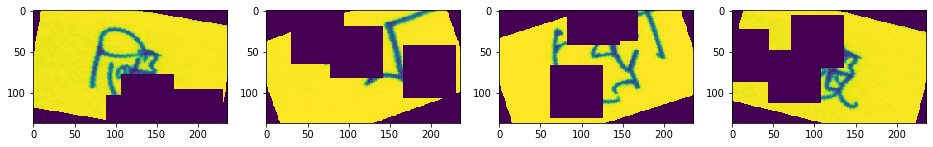

In [0]:
MODEL_MEAN = (0.485, 0.456, 0.406)
MODEL_STD = (0.229, 0.224, 0.225)
IMG_HEIGHT = 137
IMG_WIDTH = 236

f0 = pd.read_feather(PATH + 'train_data_0_128.feather')
train = pd.read_csv(PATH + 'train.csv')

tr = transforms.Compose([transforms.Resize([IMG_HEIGHT, IMG_WIDTH]),
                         transforms.RandomRotation(degrees=20),                         
                         transforms.ToTensor(),
                         Cutout(n_holes=3, length=65),
                         transforms.Normalize(MODEL_MEAN, MODEL_STD),
                                            ])

data = BengaliDatasetTrain(f0.iloc[:10],
                           train.iloc[:10],
                           img_height= IMG_HEIGHT,
                           img_width=IMG_WIDTH,
                           mean=MODEL_MEAN,
                           std=MODEL_STD, transforms= tr) 
dataloader = DataLoader(data, batch_size=10, shuffle=True)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 8)) 
for i in range(4):
    #img, _ = data[i] # torch.Size([1, 64, 64])
    img, _ = next(iter(dataloader))
    
    #print(img.shape)
    #ax[i].imshow(img.view(64, 64)) 
    print(img.shape)
    ax[i].imshow(img[0][0])

##Model

In [0]:
class BengaliDatasetTest:
    def __init__(self, df, img_height, img_width, mean, std):
        
        self.image_ids = df.image_id.values
        self.img_arr = df.iloc[:, 1:].values
        self.aug = albumentations.Compose([
            albumentations.Resize(img_height, img_width, always_apply=True),
            albumentations.Normalize(mean, std, always_apply=True)
        ])

    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, item):
        image = self.img_arr[item, :]
        img_id = self.image_ids[item]
        image = image.reshape(137,236).astype(float)
        image = Image.fromarray(image).convert("RGB")     
        image = self.aug(image=np.array(image))["image"]
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        return{
            'image': torch.tensor(image, dtype=torch.float),
            "image_id":img_id
        }

In [0]:
# weight = '/kaggle/input/efficientnetpytorch/EfficientNet-PyTorch/efficientnet_weights/efficientnet-b3.pth'

# class EfficientNetB3(nn.Module):
    
#     def __init__(self, pretrained):
#         super(EfficientNetB3, self).__init__()
#         self.model = EfficientNet.from_name('efficientnet-b3')

#         if pretrained is True:
#             self.model = EfficientNet.from_pretrained("efficientnet-b3")            
#             #self.model.load_state_dict(torch.load(weight))
        
#         self.l0 = nn.Linear(1536, 11)
#         self.l1 = nn.Linear(1536, 168)        
#         self.l2 = nn.Linear(1536, 7)

#     def forward(self, x):
#         bs, _, _, _ = x.shape
#         x = self.model.extract_features(x)
#         x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
#         l0 = self.l0(x)
#         l1 = self.l1(x)
#         l2 = self.l2(x)

#         return l0, l1, l2

#######################################################################################################
from torchvision import models

class DoubleLinear(torch.nn.Module):
    def __init__(self, Linear1, Linear2, Linear3):
        super(DoubleLinear, self).__init__()
        self.Linear1 = Linear1
        self.Linear2 = Linear2
        self.Linear3 = Linear3

    def forward(self, input):
        return self.Linear1(input), self.Linear2(input), self.Linear3(input)
    
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

#resnet18 = models.resnet18(pretrained=False)
model = models.resnext50_32x4d(pretrained=True)

# feature_extract = False
# set_parameter_requires_grad(model, feature_extract)
target1, target2, target3 = 11, 168, 7

Linear_first = nn.Linear(2048, target1)
Linear_second = nn.Linear(2048, target2)
Linear_therd = nn.Linear(2048, target3)

model.fc = DoubleLinear(Linear_first, Linear_second, Linear_therd)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode="min",
                                                       patience=5,
                                                       factor=0.3,verbose=True)
criterion = nn.CrossEntropyLoss()

In [0]:
# model = models.resnext50_32x4d(pretrained=True)
# model.load_state_dict(torch.load('/content/drive/My Drive/Bengali/model/b3_20sample_add_cutout_20_epoches_4_folds_add_9.pth'))
# model.to(device)

In [0]:
# from efficientnet_pytorch import EfficientNet
# model = EfficientNetB3(pretrained=False)
# model.load_state_dict(torch.load('/content/drive/My Drive/Bengali/model/b3_20sample_add_cutout_20_epoches_4_folds_add_9.pth'))
# model.to(device)

In [0]:
# # #optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# # # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
# # #                                                        mode="min",
# # #                                                        patience=3,
# # #                                                        factor=0.3,verbose=True)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1)
# criterion = nn.CrossEntropyLoss()

In [0]:
!pip install iterative-stratification

In [0]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
mskf = MultilabelStratifiedKFold(n_splits=4)
X = train.image_id.values
y = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
splits = list(mskf.split(X, y))

In [0]:
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=7, verbose=False, delta=0):
      """
      Args:
          patience (int): How long to wait after last time validation loss improved.
                          Default: 7
          verbose (bool): If True, prints a message for each validation loss improvement. 
                          Default: False
          delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                          Default: 0
      """
      self.patience = patience
      self.verbose = verbose
      self.counter = 0
      self.best_score = None
      self.early_stop = False
      self.val_loss_min = np.Inf
      self.delta = delta

  def __call__(self, val_loss, model):

      score = -val_loss

      if self.best_score is None:
          self.best_score = score
          self.save_checkpoint(val_loss, model)
      elif score < self.best_score + self.delta:
          self.counter += 1
          print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
          if self.counter >= self.patience:
              self.early_stop = True
      else:
          self.best_score = score
          self.save_checkpoint(val_loss, model)
          self.counter = 0

  def save_checkpoint(self, val_loss, model):
      '''Saves model when validation loss decrease.'''
      if self.verbose:
          print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
      torch.save(model.state_dict(), 'checkpoint.pt')
      self.val_loss_min = val_loss

In [0]:
def ohem_loss( rate, cls_pred, cls_target ):

    batch_size = cls_pred.size(0) 
    ohem_cls_loss = F.cross_entropy(cls_pred, cls_target, reduction='none', ignore_index=-1)

    sorted_ohem_loss, idx = torch.sort(ohem_cls_loss, descending=True)
    keep_num = min(sorted_ohem_loss.size()[0], int(batch_size*rate) )
    if keep_num < sorted_ohem_loss.size()[0]:
        keep_idx_cuda = idx[:keep_num]
        ohem_cls_loss = ohem_cls_loss[keep_idx_cuda]
    cls_loss = ohem_cls_loss.sum() / keep_num
    return cls_loss


def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets
# loss 
def cutmix_criterion(preds1,preds2,preds3, targets, rate=0.7):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    # criterion = nn.CrossEntropyLoss(reduction='mean')
    criterion = ohem_loss
    return [lam * criterion(rate, preds1, targets1) + (1 - lam) * criterion(rate, preds1, targets2),
            lam * criterion(rate, preds2, targets3) + (1 - lam) * criterion(rate, preds2, targets4),
            lam * criterion(rate, preds3, targets5) + (1 - lam) * criterion(rate, preds3, targets6) ]


def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def mixup_criterion(preds1,preds2,preds3, targets, rate=0.7):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    # criterion = nn.CrossEntropyLoss(reduction='mean')
    criterion = ohem_loss
    return [lam * criterion(rate, preds1, targets1) + (1 - lam) * criterion(rate, preds1, targets2),
            lam * criterion(rate, preds2, targets3) + (1 - lam) * criterion(rate, preds2, targets4),
            lam * criterion(rate, preds3, targets5) + (1 - lam) * criterion(rate, preds3, targets6) ]

In [0]:
def plot_img(img):
    fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(16, 8)) 
    num = 0
    for nr in range(3):
        for col in range(4):
            ax[nr][col].imshow(img[num][0].cpu().detach().numpy(), cmap='gray')
            num +=1
    plt.show()

epochs 1/20 

Fold: 1



  0%|          | 1/202 [00:02<07:35,  2.27s/it]

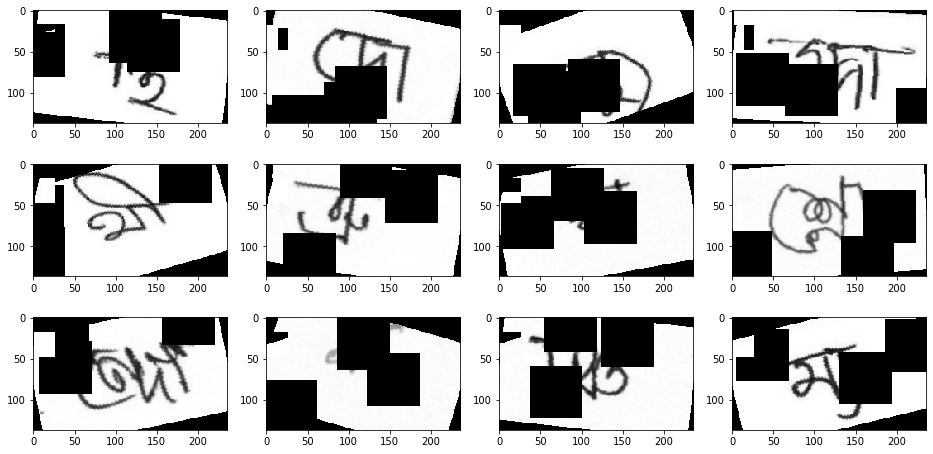

100%|██████████| 101/101 [00:54<00:00,  1.87it/s]



--------------------------------------------------

acc : 0.61%, loss : 10.0356,  Vla_acc : 0.53%, Val_loss : 5.9237

Fold: 2



100%|██████████| 101/101 [00:54<00:00,  1.85it/s]



--------------------------------------------------

acc : 0.78%, loss : 7.5308,  Vla_acc : 0.61%, Val_loss : 4.7321

Fold: 3



100%|██████████| 101/101 [00:54<00:00,  1.85it/s]



--------------------------------------------------

acc : 0.90%, loss : 6.1830,  Vla_acc : 0.67%, Val_loss : 3.9768

Fold: 4



100%|██████████| 101/101 [00:54<00:00,  1.86it/s]



--------------------------------------------------

acc : 1.04%, loss : 5.5397,  Vla_acc : 0.71%, Val_loss : 3.2697
Validation loss decreased (inf --> 330.241058).  Saving model ...
epochs 2/20 

Fold: 1



100%|██████████| 101/101 [00:54<00:00,  1.86it/s]



--------------------------------------------------

acc : 1.01%, loss : 4.6722,  Vla_acc : 0.73%, Val_loss : 3.0438

Fold: 2



 82%|████████▏ | 166/202 [05:38<01:13,  2.04s/it]

In [0]:
epochs = 20
BATCH_SIZE = 64
MODEL_MEAN = (0.485, 0.456, 0.406)
MODEL_STD = (0.229, 0.224, 0.225)
IMG_HEIGHT = 137
IMG_WIDTH = 236

fold = [f'Fold_{i}' for i in range(4)]
is_plot_c = True
ALPHA = .2
early_stopping = EarlyStopping(patience=5, verbose=True)
best_score = -1
for epoch in range(epochs): 
    print('epochs {}/{} '.format(epoch+1,epochs))
    print('================================')
    for i, (train_idx, valid_idx) in enumerate(splits):
        print(f'\nFold: {i + 1}\n')
        reduced_index = train.iloc[train_idx].groupby(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']).apply(lambda x: x.sample(10)).image_id.values
        reduced_index_valid = train.iloc[valid_idx].groupby(['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']).apply(lambda x: x.sample(5)).image_id.values
        #reduced_index = train.iloc[train_idx].image_id.values
        #reduced_index_valid = train.iloc[valid_idx].image_id.values
    
        running_loss = 0
        running_acc = 0.0
        valid_loss, valid_acc = 0, 0
        to_do = {'train': reduced_index, 'valid': reduced_index_valid}
        for mark in to_do:
            reduced_train = train.loc[train.image_id.isin(to_do[mark])]
            reduced_data = images.loc[images.image_id.isin(to_do[mark])]
            #data = Dataset(reduced_data, reduced_train, train= 'train', transform=transf)
            tr = transforms.Compose([transforms.Resize([IMG_HEIGHT, IMG_WIDTH]),
                                     transforms.RandomRotation(degrees=20),
                                     transforms.ToTensor(),
                                     Cutout(n_holes=3, length=65),
                                     transforms.Normalize(MODEL_MEAN, MODEL_STD),
                                     ])

            data = BengaliDatasetTrain(reduced_data, reduced_train,
                                       img_height= IMG_HEIGHT,
                                       img_width=IMG_WIDTH,
                                       mean=MODEL_MEAN,
                                       std=MODEL_STD, transforms = tr)  
            dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)
            iters = len(dataloader)
            if mark == 'train':
                model.train()
            else:
                model.eval()
            for idx, (img, labels) in tqdm(enumerate(dataloader),total=len(dataloader)):
                img = img.to(device)
                lab1 = labels[:, 0].to(device)
                lab2 = labels[:, 1].to(device)
                lab3 = labels[:, 2].to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(mark == 'train'): #True, False is Cool
                    
                    ###############
                    is_cutmix = False
                    if mark == 'train':
                        inits = np.random.rand() 
                        if (inits >= 0.3 and inits < 0.6):
                            img, targets = cutmix(img, lab1, lab2, lab3, ALPHA)
                            is_cutmix = True
                            if is_plot_c: 
                                plot_img(img)
                                is_plot_c = False #plots ones 
                    ###############
                
                    outputs1,outputs2,outputs3 = model(img.float())  
                    loss1 = criterion(outputs1,lab1)
                    loss2 = criterion(outputs2,lab2)
                    loss3 = criterion(outputs3,lab3)
                    
                    if mark == 'train':
                      if is_cutmix:
                        loss = cutmix_criterion(outputs1,outputs2,outputs3, targets)
                        #loss_cutmix += torch.stack(loss).sum().item()
                      else:            
                        running_loss += loss1+loss2+loss3
                        running_acc += (outputs1.argmax(1)==lab1).float().mean()
                        running_acc += (outputs2.argmax(1)==lab2).float().mean()
                        running_acc += (outputs3.argmax(1)==lab3).float().mean()
                    else:
                      valid_loss += loss1+loss2+loss3   
                      valid_acc += (outputs1.argmax(1)==lab1).float().mean()
                      valid_acc += (outputs2.argmax(1)==lab2).float().mean()
                      valid_acc += (outputs3.argmax(1)==lab3).float().mean()                   
                        
                    if mark == 'train':
                        if is_cutmix:
                          torch.stack(loss).sum().backward() 
                        else:
                          (loss1+loss2+loss3).backward() 
                        optimizer.step()
                        #scheduler.step(epoch + idx / iters)

        print('\n--------------------------------------------------\n')
        scheduler.step(valid_loss) 

        if valid_loss > best_score:
          best_score = valid_loss
          torch.save(model.state_dict(), f"/content/drive/My Drive/Bengali/checkpoint/erlystop_{best_score}.pth")  

        acc, loss = running_acc/(len(dataloader)*3), running_loss/len(dataloader)
        acc_v, loss_v = valid_acc/(len(dataloader)*3),valid_loss/len(dataloader)
        print('acc : {:.2f}%, loss : {:.4f},  Vla_acc : {:.2f}%, Val_loss : {:.4f}'.format(acc, loss, acc_v, loss_v))
        
    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    torch.save(model.state_dict(), f"b3_checkpoint_epoches{epoch}.pth")        

In [0]:
torch.save(model.state_dict(),'resnet_10sample_add_cutout_cutmix_20epoches.pth')

In [0]:
#model.load_state_dict(torch.load('/kaggle/input/model-v2/b3_add_5_epoches1.pth'))


In [0]:
IMG_HEIGHT = 137
IMG_WIDTH = 236

TEST_BATCH_SIZE = 16

predictions = []
model.eval()
for file_idx in range(4):
    df = pd.read_parquet(f'/kaggle/input/bengaliai-cv19/test_image_data_{file_idx}.parquet')
    dataset = BengaliDatasetTest(df = df,
                                 img_height=IMG_HEIGHT,
                                 img_width=IMG_WIDTH,
                                 mean=MODEL_MEAN,
                                 std=MODEL_STD)
                                  
    data_loader = torch.utils.data.DataLoader(dataset,
                                              batch_size=TEST_BATCH_SIZE,
                                              shuffle=False,
                                              num_workers=0)
    with torch.no_grad():
        for bi, d in enumerate(data_loader):
            image = d['image']           
            img_id = d['image_id']

            v, g, c = model(image.float().to(device))
            gg = g.cpu().detach().numpy()
            vv = v.cpu().detach().numpy()
            cc = c.cpu().detach().numpy()      
            g = np.argmax(gg, axis=1)
            v = np.argmax(vv, axis=1)
            c = np.argmax(cc, axis=1)
            for ii, imid in enumerate(img_id):
                predictions.append((f"{imid}_consonant_diacritic", int(c[ii])))
                predictions.append((f"{imid}_grapheme_root", int(g[ii])))
                predictions.append((f"{imid}_vowel_diacritic", int(v[ii])))
                

lab1 = self.label.vowel_diacritic.values[idx]

lab2 = self.label.grapheme_root.values[idx]

lab3 = self.label.consonant_diacritic.values[idx]

return torch.tensor(img), torch.tensor([lab1, lab2, lab3]) 

In [0]:
sub = pd.DataFrame(predictions, columns = ['row_id', 'target'])

In [0]:
sub

In [0]:
sub.to_csv('submission.csv', index=False)